# Dataframe link :
https://www.kaggle.com/datasets/tarekmuhammed/patients-data-for-medical-field

# The imports :

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib
import os


pd.set_option('display.max_columns', None)  

# Reading and consultation

In [2]:
df = pd.read_excel('Patients Data ( Used for Heart Disease Prediction ).xlsx')

In [14]:
df.head(1)

,PatientID,State,Sex,GeneralHealth,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HadHeartAttack,HadAngina,HadStroke,HadAsthma,HadSkinCancer,HadCOPD,HadDepressiveDisorder,HadKidneyDisease,HadArthritis,HadDiabetes,DeafOrHardOfHearing,BlindOrVisionDifficulty,DifficultyConcentrating,DifficultyWalking,DifficultyDressingBathing,DifficultyErrands,SmokerStatus,ECigaretteUsage,ChestScan,RaceEthnicityCategory,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,1,Alabama,Female,Fair,Age 75 to 79,1.63,84.82,32.099998,0,1,0,1,1,0,0,0,1,Yes,0,0,0,1,0,0,Former smoker,Never used e-cigarettes in my entire life,1,"White only, Non-Hispanic",0,0,0,1,"No, did not receive any tetanus shot in the past 10 years",0,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237630 entries, 0 to 237629
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   PatientID                  237630 non-null  int64  
 1   State                      237630 non-null  object 
 2   Sex                        237630 non-null  object 
 3   GeneralHealth              237630 non-null  object 
 4   AgeCategory                237630 non-null  object 
 5   HeightInMeters             237630 non-null  float64
 6   WeightInKilograms          237630 non-null  float64
 7   BMI                        237630 non-null  float64
 8   HadHeartAttack             237630 non-null  int64  
 9   HadAngina                  237630 non-null  int64  
 10  HadStroke                  237630 non-null  int64  
 11  HadAsthma                  237630 non-null  int64  
 12  HadSkinCancer              237630 non-null  int64  
 13  HadCOPD                    23

# Preparing the functions for training and getting best model

In [ ]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    # Initialize models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42)
        # 'SVM': SVC(random_state=42)
    }
    
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Generate confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Store results
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred)
        }
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}\nAccuracy: {accuracy:.4f}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        print(f"\nClassification Report for {name}:")
        print(results[name]['classification_report'])
    
    return results

# Function to find best model
def get_best_model(results):
    best_accuracy = 0
    best_model_name = None
    
    for name, result in results.items():
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model_name = name
    
    return best_model_name, best_accuracy



# Functions for saving the model

In [41]:
def save_model_components(model, scaler, label_encoders, categorical_columns, best_model_name):
    # Create a directory for saving if it doesn't exist
    if not os.path.exists('model'):
        os.makedirs('model')
    
    # Save the model
    joblib.dump(model, 'model/best_model.pkl')
    
    # Save the scaler
    joblib.dump(scaler, 'model/scaler.pkl')
    
    # Save label encoders with their column names
    encoder_dict = {}
    for col, le in zip(categorical_columns, label_encoders):
        encoder_dict[col] = le
    joblib.dump(encoder_dict, 'model/label_encoders.pkl')
    
    # Save categorical columns list
    joblib.dump(categorical_columns, 'model/categorical_columns.pkl')
    
    # Save model name
    with open('model/model_info.txt', 'w') as f:
        f.write(best_model_name)

# Processing

In [ ]:
def process(df):
    # Define categorical columns
    categorical_columns = ['State', 'Sex', 'GeneralHealth', 'AgeCategory', 'HadDiabetes',
                         'SmokerStatus', 'ECigaretteUsage', 'RaceEthnicityCategory', 
                         'TetanusLast10Tdap']
    
    # Create copy of dataframe
    df_model = df.copy()
    
    # Drop PatientID
    df_model = df_model.drop('PatientID', axis=1)
    
    # Initialize and fit label encoders
    label_encoders = []
    for col in categorical_columns:
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])
        label_encoders.append(le)
    
    # Split features and target
    X = df_model.drop('HadHeartAttack', axis=1)
    y = df_model['HadHeartAttack']
    joblib.dump(X.columns.tolist(), "feature_order.pkl")
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Train all models and get results
    results = train_and_evaluate_models(X_train_scaled, scaler.transform(X_test), y_train, y_test)
    
    # Get best model
    best_model_name, _ = get_best_model(results)
    best_model = results[best_model_name]['model']
    
    # Save everything
    save_model_components(best_model, scaler, label_encoders, categorical_columns, best_model_name)
    
    print(f"Model and components saved successfully. Best model: {best_model_name}")



# Results :


Training Logistic Regression...


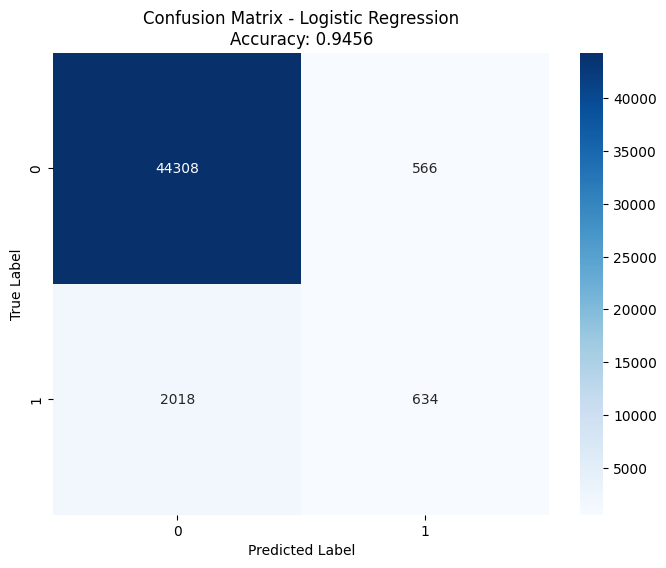


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     44874
           1       0.53      0.24      0.33      2652

    accuracy                           0.95     47526
   macro avg       0.74      0.61      0.65     47526
weighted avg       0.93      0.95      0.94     47526


Training Decision Tree...


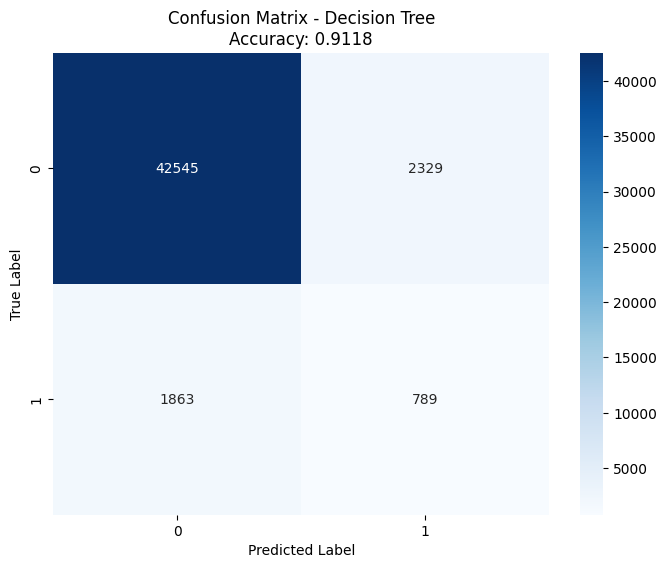


Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     44874
           1       0.25      0.30      0.27      2652

    accuracy                           0.91     47526
   macro avg       0.61      0.62      0.61     47526
weighted avg       0.92      0.91      0.92     47526


Training Random Forest...


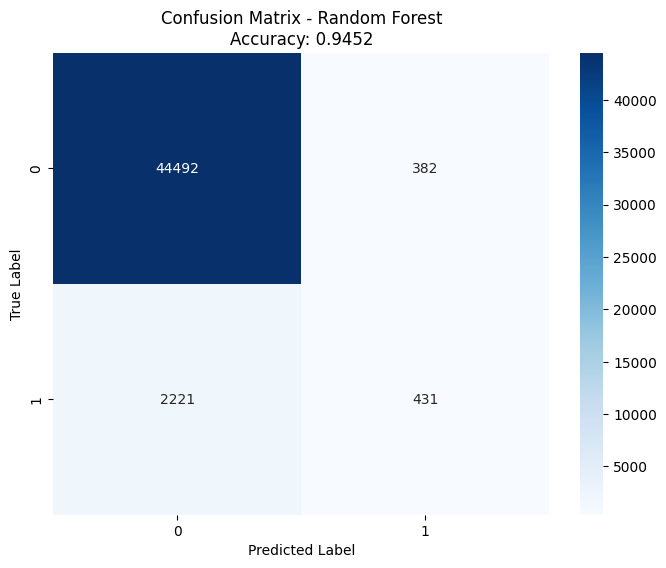


Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     44874
           1       0.53      0.16      0.25      2652

    accuracy                           0.95     47526
   macro avg       0.74      0.58      0.61     47526
weighted avg       0.93      0.95      0.93     47526

Model and components saved successfully. Best model: Logistic Regression


In [ ]:
process(df)